## First let's load and plot our dataset

In [1]:
## General librairies
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import sys
import time

from scipy.spatial.distance import cosine
## Keras utilities
import keras
import tensorflow
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
from keras.layers import Input, Conv2D, Lambda,  Dense, Flatten,MaxPooling2D,Dropout, UpSampling2D
# from tensorflow.keras.engine.input_layer import Input
from keras.layers import merge
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
import numpy.random as rng
from sklearn.utils import shuffle

## Sklearn utilities
#### Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#### Scores
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#### Feature transformations

from copy import deepcopy

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# import spacy
# nlp = spacy.load('C:/Users/gabri/Anaconda3/Lib/site-packages/en_core_web_lg/en_core_web_lg-2.2.0')


Using TensorFlow backend.


In [2]:
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

def plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    x = list(range(len(acc)))
    plt.plot(x,acc)
    plt.plot(x,val_acc)
    
def cat_to_num(y):
    y1 = []
    for i in range(y.shape[0]):
        a = 0
        for j in range(y.shape[1]):
            a += j*y[i,j]
        y1.append(int(a))
    return y1

def generate_integer():
    
    ints = []
    
    while len(ints)<5:
        r = random.randint(0,63)
        if not(r in ints):
            ints.append(r)
    return ints
    

In [3]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.

    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.

    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.

    # Returns
        Output tensor for the block.

    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x
from keras import layers
from keras import backend
def ResNet(classes):
    img_input = Input(shape=(84,84,3))
    bn_axis = 1
    
#     x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      #strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(img_input)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
#     x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
#     x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = conv_block(x, 3, [32, 32, 64], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [32, 32, 64], stage=2, block='b')
#     x = identity_block(x, 3, [32, 32, 64], stage=2, block='c')
    
    x = conv_block(x, 3, [64, 64, 128], stage=3, block='a')
    x = identity_block(x, 3, [64, 64, 128], stage=3, block='b')
#     x = identity_block(x, 3, [64, 64, 128], stage=3, block='c')

    x = conv_block(x, 3, [128, 128, 256], stage=4, block='a')
    x = identity_block(x, 3, [128, 128, 256], stage=4, block='b')
#     x = identity_block(x, 3, [128, 128, 256], stage=4, block='c')

    x = conv_block(x, 3, [256, 256, 512], stage=5, block='a')
    x = identity_block(x, 3, [256, 256, 512], stage=5, block='b')
#     x = identity_block(x, 3, [256, 256, 512], stage=5, block='c')
    x = conv_block(x, 3, [256, 256, 512], stage=6, block='a')
    x = identity_block(x, 3, [256, 256, 512], stage=6, block='b')
    
    x = conv_block(x, 3, [256, 256, 512], stage=7, block='a')
    x = identity_block(x, 3, [256, 256, 512], stage=7, block='b')
    
    x = Flatten()(x)
    
#     x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    
#     x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    
    
    model = Model(img_input, x)
    return model
    

In [ ]:
def get_model(output_shape):
    model = Sequential()

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(84,84,3)))
    model.add(Conv2D(128, (3, 3), padding = 'same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='softmax'))

    return model

def conv_net(n_classes):
    convnet = Sequential()
    convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=(84,84,3),kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    
    convnet.add(Conv2D(128,(7,7),activation='relu',
                       kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    
    convnet.add(Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    
    convnet.add(Conv2D(512,(4,4),activation='relu',kernel_regularizer=l2(2e-4)))
    convnet.add(Flatten())
    
    convnet.add(Dense(128,activation="sigmoid",kernel_regularizer=l2(1e-3)))
    
    convnet.add(Dense(n_classes,activation="sigmoid"))
    
    convnet.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adadelta(), metrics = ['accuracy'])
    return convnet


def reslayer(x, n_neuron):
    
    x1 = Conv2D(n_neuron, (3,3), activation = 'relu')(x)
    x2 = Conv2D(n_neuron, (3,3), activation = 'relu')(x1)
    x3 = keras.layers.BatchNormalization()(x2)
#     x3 = Conv2D(n_neuron, (3,3),padding = 'same', activation = 'relu')(x2)
    
    
    x_shortcut1 = Conv2D(n_neuron, (5,5), activation = 'relu')(x)
    x_shortcut2 = keras.layers.BatchNormalization()(x_shortcut1)
    
    
    conc = keras.layers.Concatenate(axis=-1)([x3, x_shortcut2])
    
    conc1 = keras.layers.BatchNormalization()(conc)
    
    final = MaxPooling2D(pool_size=(2, 2))(conc)
    
    return final

def shortlong(x, n_neuron):
    
    x1 = Conv2D(n_neuron, (3,3), activation = 'relu')(x)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = Conv2D(n_neuron, (3,3), activation = 'relu')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = Conv2D(n_neuron, (3,3), activation = 'relu')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    
    x2 = Conv2D(n_neuron, (5,5), activation = 'relu')(x)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = Conv2D(n_neuron, (3,3), activation = 'relu')(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    
    x3 = Conv2D(n_neuron, (7,7), activation = 'relu')(x)
    x3 = keras.layers.BatchNormalization()(x3)
    
#     conc = keras.layers.Concatenate(axis=-1)([x1, x2, x3])
    conc = keras.layers.add(inputs = [x1, x2, x3])
    conc = keras.layers.BatchNormalization()(conc)
    
    final = conc #MaxPooling2D(pool_size=(2, 2))(conc)
    
    return final

def resnet1(output_shape):
    input1 = Input((84,84,3))
    x = shortlong(input1, 32)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = shortlong(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = shortlong(x, 128)
#     x = shortlong(x, 512)
    
    x = Flatten()(x)
    x = Dense(128, activation ='relu')(x)
    output = Dense(output_shape, activation='softmax')(x)
    
    model = Model(input1, output)
    model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adadelta(), metrics = ['accuracy'])
    return model   

def resnet2(output_shape):
    input1 = Input((84,84,3))
    x = shortlong(input1, 64)
    x = shortlong(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = shortlong(x, 80)
    x = shortlong(x, 80)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    
    x = shortlong(x, 230)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(128, activation ='relu')(x)
    
    output = Dense(output_shape, activation='softmax')(x)
    
    model = Model(input1, output)
    model.compile(loss="categorical_crossentropy",optimizer=('adam'), metrics = ['accuracy'])
    return model 
 
    
def resnet(output_shape):
    input1 = Input((84,84,3))

    x1 = reslayer(input1,32)
    x2 = reslayer(x1, 64)
    x3 = reslayer(x2, 128)
    x4 = reslayer(x3,256)
    
    
    x5 = Dropout(0.25)(x4)
    x6 = Flatten()(x5)
    x7 = Dense(128, activation='relu')(x6)
    x8 = Dropout(0.5)(x7)
    output = Dense(output_shape, activation='softmax')(x8)

    model = Model(input1, output)
    
    model.compile(loss="categorical_crossentropy",optimizer='adam', metrics = ['accuracy'])
    return model

In [ ]:
# model1 = resnet2(64)
# model1.summary()

In [ ]:
OT = pickle.load(open('miniImageNet_category_split_train_phase_train.pickle', 'rb'), encoding='latin1')

In [ ]:
OT.keys()

In [ ]:
for i in range(5):
    plt.figure(i)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
    ax1.imshow(OT['data'][600*i+1])
    ax2.imshow(OT['data'][600*i+2])    
    ax3.imshow(OT['data'][600*i+3])
    ax4.imshow(OT['data'][600*i+4])
    ax5.imshow(OT['data'][600*i+5])

# 1) Setting up a baseline using all the dataset

### a) Preparing a train set and a test set

In [ ]:
Y = OT['labels']
X = OT['data']

# X, Y = load('training set cleaned')

In [ ]:
X_meta = deepcopy(X)
y_meta = deepcopy(np.array(Y)+5)


In [ ]:

 y = np_utils.to_categorical(Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### b) Baseline 

Pour cette baseline, le but sera de passer notre dataset dans une dimension d'image embedding avec les couches d'extraction de features d'un VGG16, puis de classifier les images à l'aide d'une régression logistique

In [ ]:
# from keras.applications import VGG16
# from keras.applications import ResNet50
# from keras.applications.inception_v3 import InceptionV3
# vgg_conv = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape=(84, 84, 3))

# vgg_conv = ResNet50(include_top=False, weights='imagenet', input_shape=(84,84,3))
# vgg_conv = InceptionV3(include_top=False, weights='imagenet', input_shape=(84,84,3))
# vgg_conv = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(84,84,3))


# model = Sequential()
# model.add(vgg_conv)

# model.add(Dropout(0.25))
# model.add(Flatten())



model_transfert = load('2.resnet2 with augmentation1', 'model')
inputs = model_transfert.input
outputs = model_transfert.get_layer('batch_normalization_439').output
outputs = Flatten()(outputs)
model = Model(inputs=inputs,   outputs=outputs)

In [ ]:
Xt = model.predict(X_train)
Xv = model.predict(X_test)
yt = cat_to_num(y_train)
yv = cat_to_num(y_test)
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 1000)
# clf = RandomForestClassifier(n_estimators=200, max_depth=15,random_state=0, n_jobs = -1)
# clf = SVC(gamma='auto')


clf.fit(Xt,yt)
y_pred = clf.predict(Xv)

accuracy_score(yv, y_pred)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, shuffle = True)

Y = np.array(Y)

Y_pred = np.zeros(Y.shape[0])-1

for train_ind, test_ind in kf.split(X):
    X_train, X_test = X[train_ind], X[test_ind]
    y_train, y_test = Y[train_ind], Y[test_ind]
    
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    print("embedding créé")
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt,y_train)
    y_pred = clf.predict(Xv)
    
    print(accuracy_score(y_test, y_pred))
    
    Y_pred[test_ind] = y_pred

#### b) Premier model de deep learning

Ici nous testerons un premier modèle dont l'architecture est inspirée du VGG16

In [ ]:
def get_model(output_shape):
    model = Sequential()

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(84,84,3)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='softmax'))

    return model



In [ ]:
model = get_model(5)
# model.summary()

In [ ]:

model = get_model(64)

model.summary()

batch_size = 128
epochs = 50

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save(history, '1.VGG from scratch', 'results')
save(model, '1.VGG from scratch', 'model')
plot(history)

#### c) Data augmentation

Pour réduire l'overfitting, utilisons la même architecture, mais avec une étape de data augmentation

In [ ]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

model = ResNet34((84,84,3),64)

model.summary()

batch_size = 5
epochs = 300

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save(history, '2.ResNet with augmentation', 'results')
save(model, '2.ResNet with augmentation', 'model')
plot(history)

In [ ]:
save(model, '2.resnet2 with augmentation', 'model')

In [ ]:
import tensorflow as tf

# model = load('2.resnet2 with augmentation1', 'model')

def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)


model.compile(loss=custom_loss,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])



batch_size = 64
epochs = 4

# aug = ImageDataGenerator(rotation_range=40, zoom_range=0.3,
#                          width_shift_range=0.4, height_shift_range=0.6, shear_range=0.3,
#                          horizontal_flip=True, fill_mode="nearest")

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")


history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# save(history, '2.resnet2 with augmentation', 'results')
# save(model, '2.resnet2 with augmentation', 'model')
plot(history)

In [ ]:
keras.losses.custom_loss = custom_loss
save(model, '2.resnet2 with augmentation2', 'model')

## Adding semantics into the network

In [ ]:
df = pd.read_csv('words.csv', delimiter = ';')
dico = {}
for i in range(df.shape[0]):
    dico[df.iloc[i]['label']] = df.iloc[i]['word']


In [ ]:
OT.keys()

In [ ]:
cat2label = OT['catname2label']
def builddicos(cat2label):
    label2cat = {}
    for elt in cat2label.keys():
        label2cat[cat2label[elt]]=elt


    label2word = {}
    for elt in label2cat.keys():
        label2word[elt] = dico[label2cat[elt]]

    label2vector = {}
    for elt in label2word.keys(): 
        words = label2word[elt]
        if " " in words:
            words = words.split(" ") 
            vect = np.zeros(300)
            count = 0
            for word in words:
                temp = nlp.vocab.get_vector(word)
                vect += temp
                count += 1
            vect = vect/count
        
        
        else:
            vect = nlp.vocab.get_vector(words) 
        label2vector[elt] = vect
    return cat2label, label2cat, label2word, label2vector

cat2label, label2cat, label2word, label2vector = builddicos(cat2label)


def find_closest(vect1, label2vector):
    M = -1
    classe = -1
    
    for elt in label2vector.keys():
        vect2 = label2vector[elt]
        dist = 1 - cosine(vect2, vect1)
#         print(dist)
        if dist >= M:
            M = dist
            classe = elt
    return classe, M

Y_sem = []
for elt in Y:
    Y_sem.append(label2vector[elt])

In [ ]:
a = nlp.vocab.get_vector('foot')
find_closest(a, label2vector)

In [ ]:
Y_sem = np.array(Y_sem)

In [ ]:
Y_sem.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_sem, test_size=0.2, random_state=42)

In [ ]:
model_transfert = resnet2(64)

In [ ]:
model_transfert.summary()

In [ ]:
# model_transfert = load('2.resnet2 with augmentation', 'model')
from keras.objectives import cosine_proximity

# model_transfert = resnet2(64)

# def cosine_distance(x, y):
#     x = K.l2_normalize(x, axis = -1)
#     y = K.l2_normalize(y, axis = -1)
#     return K.mean(1- K.sum(x*y, axis = -1))



inputs = model_transfert.input
#dense_25 flatten_13 batch_normalization_439 

outputs = model_transfert.get_layer('batch_normalization_70').output
outputs = Flatten()(outputs)

outputs = Dense(400, activation = 'relu')(outputs)
outputs = Dense(300, activation = 'linear')(outputs)

model = Model(inputs=inputs,   outputs=outputs)

for layer in model.layers:
     layer.trainable = True

        
# tf.keras.losses.CosineSimilarity()
import tensorflow as tf
model.compile(loss='mse', optimizer='adam', metrics = ['mse', 'cosine'])

model.summary()

In [ ]:
from keras.callbacks import LambdaCallback

def batchOutput(batch, logs):
    sys.stdout.write("\rStep {} sur  ".format(logs))
    sys.stdout.flush()
#     print("Finished batch: " + str(batch))
#     print(logs)

batchLogCallback = LambdaCallback(on_batch_end=batchOutput)

In [ ]:
# for layer in model.layers:
#      layer.trainable = True

# model.compile(loss=cosine_distance, optimizer=keras.optimizers.Adadelta())

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

batch_size = 50
epochs = 10

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, verbose = 2, callbacks=[batchLogCallback])

# history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, y_test),verbose = 2, callbacks=[batchLogCallback])

In [ ]:
save(model, '2.resnet2 with semantics finetune', 'model')

In [ ]:
model.summary()

In [ ]:
vect1 = nlp.vocab.get_vector('dog')

classe, max1 = find_closest(vect1, label2vector)

print(label2word[classe])

## Testing on test set

In [4]:
OT2 = pickle.load(open('miniImageNet_category_split_val.pickle', 'rb'), encoding='latin1')

In [5]:
OT1 = pickle.load(open('miniImageNet_category_split_test.pickle', 'rb'), encoding='latin1')

In [6]:
OT1.keys()

dict_keys(['catname2label', 'label2catname', 'labels', 'data'])

In [7]:
OT2.keys()

dict_keys(['catname2label', 'label2catname', 'labels', 'data'])

In [8]:
# cat2label1 = OT2['catname2label']
# cat2label2 = OT1['catname2label']

# for elt in cat2label2.keys():
#     cat2label1[elt] = cat2label2[elt]


# cat2label1, label2cat1, label2word1, label2vector1 = builddicos(cat2label1)


from copy import deepcopy
Y_val = deepcopy(OT2['labels'])
X_val = deepcopy(OT2['data'])

for i in OT1['labels']:
    Y_val.append(i)
X_val = np.concatenate([X_val, OT1['data']], axis = 0)

tab = []
for i in range(36):
    tab.append([])

for i in range(len(Y_val)):
    tab[Y_val[i]-64].append(X_val[i])

X = np.array(tab)


n = 5
k = 5

def choose_n_classes(n, m, M):
    tab = []
    while len(tab)<n:
        r = random.randint(m,M)
        if not(r in tab):
            tab.append(r)
    tab.sort()
    tab = np.array(tab)
    
    dico = {}
    for i in range(n):
        dico[tab[i]] = i
    
    return tab, dico

def build_dataset(X, n,k,value = True, tab = True, dico = True):
    if value == True:
        tab, dico = choose_n_classes(n, 64,99)
    
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    
    print(dico)
    
    for elt in tab:
        ind, dico1 = choose_n_classes(k, 0, 600)
        
        for i in range(600):
            if i in ind:
                x_train.append(X[elt-64,i])
                y_train.append(dico[elt])
            else:
                x_test.append(X[elt-64,i])
                y_test.append(dico[elt])
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test), tab, dico


In [20]:
n = 5
k = 5

X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)#, False, tab, dico)

# small = {}
# for elt in dico.keys():
#     small[elt] = label2vector1[elt]

{88: 0, 89: 1, 92: 2, 94: 3, 95: 4}


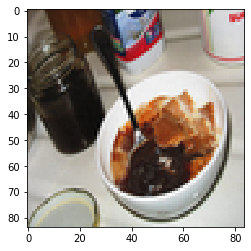

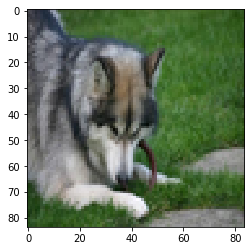

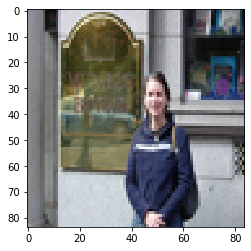

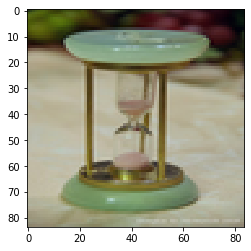

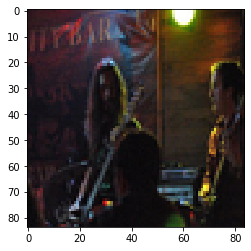

In [21]:
for i in range(5):
    plt.figure(i)
    plt.imshow(X_train[k*i])

In [22]:
model_transfert = load('2.resnet2 with augmentation1', 'model')
# model_transfert = load('2.Resnet with augmentation 65%', 'model')

inputs = model_transfert.input
#dense_25 flatten_13 batch_normalization_439 
#dense_4  avg_pool 
outputs = model_transfert.get_layer('batch_normalization_439').output
outputs = Flatten()(outputs)
# outputs = Dense(5, activation = 'softmax')(outputs)
model = Model(inputs=inputs,   outputs=outputs)

# for layer in model.layers[:59]:
#      layer.trainable = False

# model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adadelta(), metrics = ['accuracy'])

# model.summary()

In [23]:
# aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
#                          width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
#                          horizontal_flip=True, fill_mode="nearest")
# X_train, y_train = aug1(X_train, list(y_train), 32, aug)


y_test1 = np.zeros(y_test.shape[0])-1
# X_test1, y_test1 = aug1(X_test, list(y_test), 10000, aug)

y_learn = np.concatenate([y_train, y_test1])

Xt = model.predict(X_train)
print(0)
Xv = model.predict(X_test)


# Xv1 = model.predict(X_test1)
print(1)
clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', max_iter = 1000, penalty='l2')
# clf = RandomForestClassifier(n_estimators=200, max_depth=15,random_state=0, n_jobs = -1)
# clf = SVC(gamma='auto', probability = True)
from sklearn.svm import NuSVC
# clf = NuSVC(gamma='scale', kernel = 'rbf', degree = 5, nu = 0.5)


clf.fit(Xt,y_train)
y_pred = clf.predict(Xv)

accuracy_score(y_test, y_pred)

0
1


0.7257142857142858

In [24]:
import umap
reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=20)
embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)

In [25]:
a = embedding.transform(Xv)
b = embedding.transform(Xt)

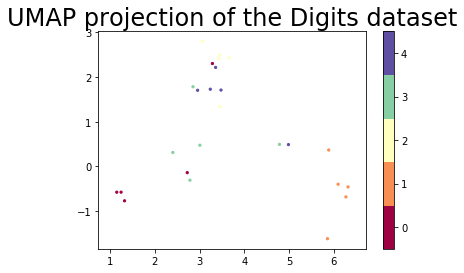

In [26]:
plt.scatter(b[:, 0], b[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

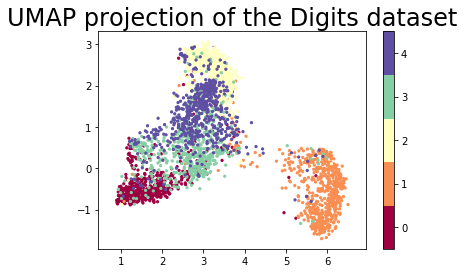

In [27]:
plt.scatter(a[:, 0], a[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

In [28]:
from sklearn.neighbors import KNeighborsClassifier
Xt1 = embedding.transform(Xt)
Xv1 = embedding.transform(Xv)
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)
# clf = RandomForestClassifier(n_estimators=200, max_depth=15,random_state=0, n_jobs = -1)
# clf = SVC(gamma='auto', probability = True)
# clf = KNeighborsClassifier(n_neighbors=3)
# clf = KNeighborsClassifier(n_neighbors=5, metric = cosine)


clf.fit(Xt1,y_train)
y_pred = clf.predict(Xv1)

accuracy_score(y_test, y_pred)

0.7489075630252101

In [29]:
confusion_matrix(y_test, y_pred)

array([[490,   6,  13,  71,  15],
       [  5, 549,   7,  13,  21],
       [  8,   1, 549,  14,  23],
       [ 80,   8,  17, 422,  68],
       [ 97,  10,  56, 214, 218]], dtype=int64)

In [30]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)

clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pred], axis = 0))
y_pred = clf.predict(Xv)
accuracy_score(y_test, y_pred)

0.7532773109243698

In [ ]:
scores1 = []
scores2 = []
scores3 = []

tab1 = [1,3, 5,10,50,100,300,500]

for k in tab1:
    X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k, False, tab, dico)
    
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    
    reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=20)
    embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)
    
    Xt1 = embedding.transform(Xt)
    Xv1 = embedding.transform(Xv)
    
    y_test1 = np.zeros(y_test.shape[0])-1
    y_learn = np.concatenate([y_train, y_test1])
    
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt1,y_train)
    y_pred = clf.predict(Xv1)
    scores2.append(accuracy_score(y_test, y_pred))
    
    print(accuracy_score(y_test, y_pred))
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt,y_train)
    y_pseudo = clf.predict(Xv)
    scores1.append(accuracy_score(y_test, y_pseudo))
    
    print(accuracy_score(y_test, y_pred))
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt1,y_train)
    y_pred = clf.predict(Xv1)
    scores2.append(accuracy_score(y_test, y_pred))
    
    print(accuracy_score(y_test, y_pred))
    
    
plt.plot(tab1, scores1)
plt.plot(tab1, scores2)

In [ ]:
def send_new(X_train, X_test, y_train, y_test, clf, tres):
    
    proba = clf.predict_proba(X_test)
    
    X = deepcopy(X_train)
    y = list(deepcopy(y_train))
    X1 = deepcopy(X_test)
    y1 = deepcopy(y_test)
      
    vect0 = ""
    for i in range(5):

        vect = proba[:,i] >= tres
#         vect = proba[:,i] <= 1-tres
        if vect0 == "":
            vect0 = vect
        else:
            vect0 = vect0|vect

        X = np.concatenate([X, X1[vect, :]])

        for elt in vect:
            if elt:
                y.append(i)

    X1 = X1[vect0 == False,:]
    y1 = y1[vect0 == False]
    
    return X, X1, y, y1

In [32]:
scores = []

n = 5
k = 1

for i in range(100):
    X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)
    
#     aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
#                          width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
#                          horizontal_flip=True, fill_mode="nearest")
#     X_train, y_train = aug1(X_train, list(y_train), 32, aug)
#     X_test, y_test = augment(X_test, list(y_test))
#     print('augmented')
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
    clf.fit(Xt,y_train)
    y_pred = clf.predict(Xv)
    
    print(accuracy_score(y_test, y_pred))
    
    y_test1 = np.zeros(y_test.shape[0])-1
    y_learn = np.concatenate([y_train, y_test1])
    
    reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=20)
    embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)
    Xt1 = embedding.transform(Xt)
    Xv1 = embedding.transform(Xv)
 
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
    clf.fit(Xt1,y_train)
    y_pred = clf.predict(Xv1)
    
    print(accuracy_score(y_test, y_pred))
    
#     a = accuracy_score(y_test, y_pred)
#     print(a)
    
#     Xt1 , Xv1, yt1, yv1 = send_new(Xt, Xv, y_train, y_test, clf, 1)

#     for i in range(10):
#         if i != 0:
#             Xt1 , Xv1, yt1, yv1 = send_new(Xt1 , Xv1, yt1, yv1, clf, 0.8)
#         else:
#             Xt1 , Xv1, yt1, yv1 = send_new(Xt1 , Xv1, yt1, yv1, clf, 0.95)
#         clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)


#         clf.fit(Xt1,yt1)
#         y_pred = clf.predict(Xv)

# #         print(accuracy_score(y_test, y_pred))
#     clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
#     clf.fit(Xt1, yt1)
#     y_pred = clf.predict(Xv)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)

    clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pred], axis = 0))
    y_pred = clf.predict(Xv)
    accuracy_score(y_test, y_pred)
    
    a = accuracy_score(y_test, y_pred)
    print(a)
    
    scores.append(a)
print(np.array(scores).mean())

{69: 0, 74: 1, 92: 2, 96: 3, 98: 4}
0.6567612687813021
0.9048414023372288
0.9098497495826378
{67: 0, 76: 1, 77: 2, 93: 3, 96: 4}
0.37429048414023375
0.6524207011686144
0.6550918196994991
{65: 0, 75: 1, 86: 2, 97: 3, 99: 4}
0.6928213689482471
0.8430717863105175
0.8457429048414024
{75: 0, 87: 1, 88: 2, 93: 3, 99: 4}
0.5252086811352253
0.866110183639399
0.8654424040066778
{66: 0, 74: 1, 86: 2, 96: 3, 98: 4}
0.5125208681135225
0.778297161936561
0.7769616026711186
{66: 0, 71: 1, 80: 2, 88: 3, 90: 4}
0.6938230383973288
0.9135225375626044
0.9161936560934891
{70: 0, 71: 1, 82: 2, 90: 3, 97: 4}
0.5038397328881469
0.771619365609349
0.7843071786310517
{72: 0, 76: 1, 77: 2, 80: 3, 96: 4}
0.403338898163606
0.6717863105175292
0.671118530884808
{69: 0, 75: 1, 86: 2, 93: 3, 96: 4}
0.512186978297162
0.6944908180300501
0.7031719532554257
{69: 0, 74: 1, 75: 2, 86: 3, 93: 4}
0.40434056761268783
0.7479131886477463
0.7555926544240401
{65: 0, 67: 1, 77: 2, 89: 3, 90: 4}
0.30150250417362273
0.4260434056761268

0.5048414023372287
0.6614357262103506
0.6631051752921536
{70: 0, 71: 1, 78: 2, 79: 3, 80: 4}
0.4213689482470785
0.698831385642738
0.7018363939899833
{75: 0, 80: 1, 82: 2, 91: 3, 96: 4}
0.4888146911519199
0.805008347245409
0.8060100166944908
{72: 0, 79: 1, 82: 2, 94: 3, 95: 4}
0.5943238731218697
0.8190317195325543
0.8273789649415693
{84: 0, 86: 1, 95: 2, 96: 3, 97: 4}
0.6010016694490818
0.7252086811352254
0.7275459098497495
{67: 0, 80: 1, 85: 2, 93: 3, 95: 4}
0.48747913188647746
0.6938230383973288
0.6974958263772955
{64: 0, 75: 1, 80: 2, 91: 3, 94: 4}
0.5225375626043406
0.6080133555926545
0.606677796327212
{69: 0, 72: 1, 88: 2, 89: 3, 94: 4}
0.5115191986644407
0.6751252086811352
0.6747913188647746
{77: 0, 79: 1, 81: 2, 83: 3, 86: 4}
0.48046744574290484
0.5649415692821369
0.5696160267111853
{70: 0, 73: 1, 80: 2, 90: 3, 92: 4}
0.6100166944908181
0.8657762938230384
0.8684474123539232
{70: 0, 71: 1, 76: 2, 77: 3, 86: 4}
0.4297161936560935
0.49015025041736227
0.48914858096828046
{66: 0, 72: 

In [ ]:
print(np.array(scores).mean())

In [ ]:
plt.hist(scores)

In [ ]:
np.array(scores).min()

In [ ]:
np.array(scores).max()

In [ ]:
def aug1(X, Y, size, aug):
    
    X_aug = [0 for elt in range(size)]
    y_aug = [0 for elt in range(size)]
    
    for i in range(size):
        a = random.randint(0,X.shape[0]-1)
        X_aug[i] = aug.random_transform(X[a])
        y_aug[i] = Y[a]
    X_aug =  np.array(X_aug)   
    y_aug = np.array(y_aug)
    
    X_aug = np.concatenate([X, X_aug], axis = 0)
    y_aug = np.concatenate([Y, y_aug])
    return X_aug, y_aug

In [ ]:
scores = []

n = 5
k = 5

for i in range(100):
    X_train, X_test, y_train, y_test = build_dataset(X, n, k)
    y_t = np_utils.to_categorical(y_train)
    y_v = np_utils.to_categorical(y_test)
    
#     model_transfert = load('2.resnet2 with augmentation', 'model')
    
    inputs = model_transfert.input
    #dense_25 flatten_13
    outputs = model_transfert.get_layer('dense_25').output
    
    model1 = Model(inputs = inputs, outputs = outputs)
    
    outputs = Dense(5, activation = 'softmax')(outputs)
    
    del model
    
    model = Model(inputs=inputs,   outputs=outputs)
    for layer in model.layers:
        layer.trainable = True

    for layer in model.layers[:-2]:
         layer.trainable = False
    model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adadelta(), metrics = ['accuracy'])
    
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")
    batch_size = 100
    
    epochs = 20

    history = model.fit_generator(aug.flow(X_train, y_t, batch_size=batch_size), steps_per_epoch=20,#len(X_train) // batch_size,
    #     validation_data = (X_test, y_v),
                              epochs=epochs, verbose = 0)

    a = model.evaluate(X_test, y_v)[1]
    print("experiment "+str(i))
    print('experiment score : '+str(a))
#     print("average so far : "+ str(np.array(scores).mean()))
    scores.append(a)
    print("average so far : "+ str(np.array(scores).mean()))
    
    
    Xt = model1.predict(X_train)
    Xv = model1.predict(X_test)
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt,y_train)
    y_pred = clf.predict(Xv)

    a = accuracy_score(y_test, y_pred)
    print(a)
    
print(np.array(scores).mean())

In [ ]:
np.array(scores).min()

In [ ]:
# model_transfert = load('2.resnet2 with augmentation', 'model')
inputs = model_transfert.input
#dense_25 flatten_13
outputs = model_transfert.get_layer('dense_25').output
outputs = Dense(5, activation = 'softmax')(outputs)

model = Model(inputs=inputs,   outputs=outputs)

for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:-2]:
     layer.trainable = False

# for layer in model.layers[:59]:
#      layer.trainable = False

model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adadelta(), metrics = ['accuracy'])


In [ ]:
y_t = np_utils.to_categorical(y_train)
y_v = np_utils.to_categorical(y_test)

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")


# for layer in model.layers:
#     layer.trainable = True


# for layer in model.layers[:59]:
#      layer.trainable = False
# model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adadelta(), metrics = ['accuracy'])


# aug = ImageDataGenerator(rotation_range=40, zoom_range=0.3,
#                          width_shift_range=0.4, height_shift_range=0.6, shear_range=0.3,
#                          horizontal_flip=True, fill_mode="nearest")

batch_size = 5
epochs = 25

history = model.fit_generator(aug.flow(X_train, y_t, batch_size=batch_size), steps_per_epoch=len(X_train) // batch_size,
#     validation_data = (X_test, y_v),
                              epochs=epochs)

# model.score(X_test, y_v)
model.evaluate(X_test, y_v)

In [ ]:
model.summary()

In [ ]:
model.evaluate(X_test, y_v)

In [ ]:
inputs = model.input
#dense_25
outputs = model.get_layer('dense_25').output

# outputs = Dense(5, activation = 'softmax')(outputs)

model1 = Model(inputs=inputs,   outputs=outputs)

# model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adadelta(), metrics = ['accuracy'])


In [ ]:
Xt = model1.predict(X_train)
print(0)
Xv = model1.predict(X_test)
print(1)
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
# clf = RandomForestClassifier(n_estimators=200, max_depth=15,random_state=0, n_jobs = -1)
# clf = SVC(gamma='auto')


clf.fit(Xt,y_train)
y_pred = clf.predict(Xv)

accuracy_score(y_test, y_pred)

In [ ]:
vgg = Sequential()
for layer in model.layers[:14]:
    vgg.add(layer)
vgg.summary()

In [ ]:
Xt = vgg.predict(X_train)
Xv = vgg.predict(X_test)
yt = cat_to_num(y_train)
yv = cat_to_num(y_test)
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
clf.fit(Xt,yt)


In [ ]:
y_pred = clf.predict(Xv)
from sklearn.metrics import accuracy_score
accuracy_score(yv, y_pred)

#### c) Transfert learning

Let's use a pretrained VGG16 in order to train our model without fine tuning

In [ ]:
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(84, 84, 3))
vgg_conv.trainable = False

# for layer in vgg_conv.layers[:15]:
#     layer.trainable = False

    
# model.summary()


Xt = vgg_conv.predict(X_train)
Xv = vgg_conv.predict(X_test)

model = Sequential()

# model.add(vgg_conv)
# model.add(Dropout(0.25))
model.add(Flatten(input_shape=(2, 2, 512)))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='softmax'))

model.summary()

batch_size = 128
epochs = 100

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(Xt, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(Xv, y_test))
score = model.evaluate(Xv, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save(history, '3.VGG16 transfer', 'results')
save(model, '3.VGG16 transfer', 'model')
plot(history)

In [ ]:
plot(history)

#### d) Small mix

In [ ]:

from classification_models import Classifiers
resnet18, preprocess_input = Classifiers.get('resnet18')
vgg_conv = resnet18((84,84,3), weights = None, include_top = False)


In [ ]:

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")


vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(84, 84, 3))
vgg_conv.trainable = False



model = Sequential()

model.add(vgg_conv)
model.add(Dropout(0.25))
model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='softmax'))

model.summary()

batch_size = 128
epochs = 100

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save(history, '3.VGG16 transfer', 'results')
save(model, '3.VGG16 transfer', 'model')
plot(history)

In [ ]:
for layer in model.layers:
    layer.trainable = True

model.summary()


batch_size = 32
epochs = 50


history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=100, #len(X_train) // batch_size,
    epochs=epochs)
plot(history)

## 2) Let's get started on few shot classification

En général, les benchmarks de few shots learning se font sur du 5 ways 1 shot or 5 ways 5 shots learning, donc restructurons notre dataset de manière à pouvoir faire ainsi

In [ ]:
Y = np.array(Y)
X = np.array(X)
X1 = []
Y1 = []
X_meta = []
Y_meta = []

keep = np.array([0,1,2,3,4])#generate_integer()
meta = [i for i in range(64) if not(i in keep)]

for i in range(len(Y)):
    if Y[i] in keep:
        X1.append(X[i])
        Y1.append(Y[i])
    else:
        X_meta.append(X[i])
        Y_meta.append(Y[i])
            
X1 = np.array(X1)
Y1 = np.array(Y1)
X_meta = np.array(X_meta)
Y_meta = np.array(Y_meta)

print(Y_meta.shape)

for i in range(5):
    for j in range(len(Y1)):
        if Y1[j] == keep[i]:
            Y1[j] = i

for i in range(59):
    for j in range(len(Y_meta)):
        if Y_meta[j] == meta[i]:
            Y_meta[j] = i

# X1 = X[Y<4]
# Y1 = Y[Y<4]
y1 = np_utils.to_categorical(Y1,num_classes=5)

# X_meta = X[Y>=4]
# Y_meta = Y[Y>=4]
y_meta = np_utils.to_categorical(Y_meta)

print(keep)
print(np.unique(Y1))

In [ ]:
print(meta)

In [ ]:
import gc

In [ ]:
gc.collect()

In [ ]:
def sample_k_shots(X, y, k):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    for i in np.unique(y):
        
#         for j in range(k):
#             y_train.append(i)
#         for j in range(500-k):
#             y_test.append(i)
        
        X2 = []
        y2 = []
        for n in range(y.shape[0]):
            if y[n] == i:
                X2.append(X[n])
                y2.append(y[n])
        
        X2 = np.array(X2)
        y2 = np.array(y2)    
        
        for j in range(X2.shape[0]):
            if j<k:
                X_train.append(X2[j])
                y_train.append(y2[j])
            else:
                X_test.append(X2[j])
                y_test.append(y2[j])
        
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

#### a) VGG16 Oracle

In [ ]:

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(84, 84, 3))

model = Sequential()
model.add(vgg_conv)
model.add(Dropout(0.25))
model.add(Flatten())

Xt = model.predict(X1)
# Xv = model.predict(X_test)
yt = Y1#np.array(cat_to_num(y1))
# yv = cat_to_num(y_test)

sample = [1,5,10,20,40,80,160,300,400,500,550,590]

results = []
for elt in sample:
    X_train, X_test, y_train, y_test = sample_k_shots(Xt, yt,elt)
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 2000)


    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    print(score)
    results.append(score)

plt.plot(sample, results)

dico = {'x_axis':sample, 'y_axis': results}
save(dico, 'few shot benchmark', 'results')

In [ ]:
confusion_matrix(y_test, y_pred)

#### b) The importance of huge datasets

In [ ]:
sample = [1,5,10,50,150,300,500]
results = []
k = 5
for k in sample:
    X_train, X_test, y_train, y_test = sample_k_shots(X1, Y1,k)
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)


    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                             width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                             horizontal_flip=True, fill_mode="nearest")

    model = get_model(5)

    model.summary()

    batch_size = 150
    epochs = 15

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

    history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
        validation_data=(X_test, y_test), steps_per_epoch=100,#len(X_train) // batch_size,
        epochs=epochs)

    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    save(history, '5 ways with data aug', 'results')
    save(model, '5 ways with data aug', 'model')
    plot(history)
    results.append(np.array(history.history['val_acc']).max())


plt.figure(5)
plt.plot(sample, results)

dico = {'x_axis':sample, 'y_axis': results}
save(dico, '3. few shot benchmark custom architecture', 'results')

In [ ]:
dico

In [ ]:
Xt.shape

In [ ]:
y_pred = history.model.predict_classes(X_test)
# y_pred = cat_to_num(y_pred)
y_t = cat_to_num(y_test)

In [ ]:

confusion_matrix(y_t, y_pred)

In [ ]:
accuracy_score(y_t, y_pred)

In [ ]:
model_transfert = Sequential()

for layer in model.layers[:14]:
    model_transfert.add(layer)

model_transfert.summary()

Xt = model_transfert.predict(X1)
# Xv = model.predict(X_test)
yt = Y1#np.array(cat_to_num(y1))
# yv = cat_to_num(y_test)

sample = [1,5,10,20,40,80,160,300,400,500]

results = []
for elt in sample:
    X_train, X_test, y_train, y_test = sample_k_shots(Xt, yt,elt)
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 2000)


    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    print(score)
    results.append(score)

plt.plot(sample, results)

dico = {'x_axis':sample, 'y_axis': results}
save(dico, 'few shot benchmark', 'results')

#### c) Transfert on yet unseen data

First training of the model

In [ ]:
gc.collect()
X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)


aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

model = get_model(59)

model.summary()

batch_size = 32
epochs = 50

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=50,#len(X_train) // batch_size,
    epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save(history, '4. Transfert on unseen data', 'results')
save(model, '4. Transfert on unseen data', 'model')
plot(history)

Retraining, with progressive increase of the batch size

In [ ]:
batch_size = 512
epochs = 50
# X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

model = load('4. Transfert on unseen data', 'model')
model.summary()
history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=50,#len(X_train) // batch_size,
    epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save(history, '4. Transfert on unseen data', 'results')
save(model, '4. Transfert on unseen data', 'model')
plot(history)

Testing on the unseen classes with raw transfer

In [ ]:
model = load('4. Transfert on unseen data', 'model')

model_transfert = Sequential()

for layer in model.layers[:14]:
    model_transfert.add(layer)

model_transfert.summary()

Xt = model_transfert.predict(X1)
# Xv = model.predict(X_test)
yt = Y1#np.array(cat_to_num(y1))
# yv = cat_to_num(y_test)

sample = [1,5,10,20,40,80,160,300,400,500]

results = []
for elt in sample:
    X_train1, X_test1, y_train1, y_test1 = sample_k_shots(Xt, yt,elt)
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 2000)


    clf.fit(X_train1,y_train1)
    y_pred = clf.predict(X_test1)

    score = accuracy_score(y_test1, y_pred)
    print(score)
    results.append(score)

plt.plot(sample, results)

dico = {'x_axis':sample, 'y_axis': results}
save(dico, 'few shot benchmark', 'results')
    

Testing on the unseen classes with raw transfer

In [ ]:


model = load('4. Transfert on unseen data', 'model')

model_transfert = Sequential()

for layer in model.layers[:14]:
    model_transfert.add(layer)

model_transfert.summary()

# Xt = model_transfert.predict(X1)
# # Xv = model.predict(X_test)
# yt = Y1#np.array(cat_to_num(y1))
# yv = cat_to_num(y_test)

sample = [1,5,10,50,160,300,500]

results = []
results_clf = []
for elt in sample:
    X_train1, X_test1, Y_train1, Y_test1 = sample_k_shots(X1, Y1,elt)
    
    y_train1 = np_utils.to_categorical(Y_train1)
    y_test1 = np_utils.to_categorical(Y_test1)
    
    
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")
    
    model_transfert = Sequential()

    for layer in model.layers[:14]:
        model_transfert.add(layer)
    
    model_transfert.add(Dense(128, activation='relu'))
    model_transfert.add(Dropout(0.5))
    model_transfert.add(Dense(5, activation='softmax'))
    
    model_transfert.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    
    batch_size = 64
    epochs = 10
    
    history = model_transfert.fit_generator(aug.flow(X_train1, y_train1, batch_size=batch_size),
        validation_data=(X_test1, y_test1), steps_per_epoch=50,#len(X_train) // batch_size,
        epochs=epochs)
    
    score = max(history.history['val_acc'])
    results.append(score)
    
    print('End of fine tuning')
    
    model1 = Sequential()
    for layer in model_transfert.layers[:14]:
        model1.add(layer)
    
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 2000)
    
    X_train2 = model1.predict(X_train1)
    X_test2 = model1.predict(X_test1)

    clf.fit(X_train2,Y_train1)
    y_pred = clf.predict(X_test2)

    score = accuracy_score(Y_test1, y_pred)
    print(score)
    results_clf.append(score)
    
    print(results)
    print(results_clf)

plt.plot(sample, results)
plt.plot(sample, results_clf)

dico = {'x_axis':sample, 'y_axis': results}
save(dico, 'testing transfert on unseen classes', 'results')
    

In [ ]:
y_train1

## Autoencoders 

In [ ]:
import keras.backend as K
import tensorflow as tf

def SSIM_cs(y_true, y_pred):
    patches_true = tf.extract_image_patches(y_true, [1, 8, 8, 1], [1, 2, 2, 1], [1, 1, 1, 1], "SAME")
    patches_pred = tf.extract_image_patches(y_pred, [1, 8, 8, 1], [1, 2, 2, 1], [1, 1, 1, 1], "SAME")

    var_true = K.var(patches_true, axis=3)
    var_pred = K.var(patches_pred, axis=3)
    std_true = K.sqrt(var_true)
    std_pred = K.sqrt(var_pred)
    c2 = 0.03 ** 2
    ssim = (2 * std_pred * std_true + c2)
    denom = (var_pred + var_true + c2)
    ssim /= denom
    ssim = tf.where(tf.is_nan(ssim), K.zeros_like(ssim), ssim)
    return 1 - K.mean(ssim)

def autoencoder(input_shape, loss):
    
    encoder = Sequential()
    
    # Encoding layers
    encoder.add(Conv2D(16, (3,3), padding = 'same', input_shape = input_shape, activation = 'relu'))
    encoder.add(MaxPooling2D((2,2), padding = 'same'))
    
    encoder.add(Conv2D(2, (3,3), padding = 'same', activation = 'relu'))
    encoder.add(MaxPooling2D((2,2), padding = 'same'))
    
#     encoder.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu'))
#     encoder.add(MaxPooling2D((2,2), padding = 'same'))
    
#     encoder.add(Conv2D(8, (3,3), padding = 'same', activation = 'relu'))
#     encoder.add(MaxPooling2D((2,2), padding = 'same'))
    
    # Encoded layer
#     encoder.add(Dense(100, activation='relu'))
    
    
    # Decoding layers
#     encoder.add(Conv2D(8, (3,3), padding = 'same', activation = 'relu'))
#     encoder.add(UpSampling2D((2,2)))
    
#     encoder.add(Conv2D(16, (3,3),  padding = 'same', activation = 'relu'))
#     encoder.add(UpSampling2D((2,2)))
    
    encoder.add(Conv2D(2, (3,3),  padding = 'same',  activation = 'relu'))
    encoder.add(UpSampling2D((2,2)))
    
    encoder.add(Conv2D(16, (3,3),  padding = 'same', activation = 'relu'))
    encoder.add(UpSampling2D((2,2)))
    
    
    encoder.add(Conv2D(3, (3,3), padding = 'same', activation = 'relu'))
    
    encoder.summary()
    
    encoder.compile(optimizer = 'adadelta', loss = loss )
    
    return encoder
    

In [ ]:
X_tot = []
for i in range(64):
    X_tot.append([])
for i in range(len(Y)):
    X_tot[Y[i]].append(X[i])
X_tot = np.array(X_tot)


n_classes = 64

X_train = X_tot[:n_classes]

X_train = X_train.reshape(n_classes*600,84,84,3)


encoder_ssim  = autoencoder((84,84,3), SSIM_cs)
encoder_mse  = autoencoder((84,84,3), 'mse')

In [ ]:
epochs = 10
batch_size = 128
history_ssim = encoder_ssim.fit(X_train, X_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

history_mse = encoder_mse.fit(X_train, X_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

In [ ]:
# save(encoder_ssim, 'encoder_ssim', 'model')
# save(encoder_mse, 'encoder_mse', 'model')

In [ ]:
i = 60
plt.figure(0)
plt.imshow(X_train[i])
plt.figure(1)
plt.imshow(encoder_ssim.predict([[X_train[i]]])[0].astype(int), cmap = 'gray')
plt.figure(2)
plt.imshow(encoder_mse.predict([[X_train[i]]])[0].astype(int))

In [ ]:
model_temp = load('encoder_mse', 'model')

In [ ]:
model_temp = encoder_ssim
model_temp = load('encoder_mse', 'model')

model = Sequential()
for layer in model_temp.layers[:6]:
    model.add(layer)
model.add(Flatten())
model.add(Dense(5, activation = 'softmax'))


In [ ]:
X1 = X_tot[:5].reshape((600*5,84,84,3))

Y1 = []
for i in range(5):
    for j in range(600):
        Y1.append(i)
        
# X1 = model.predict(X1)        

In [ ]:
X_train.shape

In [ ]:
model.summary()

In [ ]:
model = get_model(5)

## Siamese Networks

In [ ]:
def siamese_net(pretrained = "", trainable = True):
    
    convnet = Sequential()
    
    input_shape = (84,84,3)
    
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    
    if pretrained == "":
        model_conv = get_model(5)
    else:
        model_conv = load(pretrained,'model')
    
    for layer in model_conv.layers[:14]:
        convnet.add(layer)
    convnet.add(Dense(256, activation ='relu'))
    
    
    if trainable == False:
        for layer in convnet.layers[:14]:
            layer.trainable = False
    convnet.summary()
    
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    
#     L1_distance = lambda x: K.abs(x[0]-x[1])
    
#     both = keras.layers.subtract([encoded_l,encoded_r])
    
#     both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
    
    merge_layer = Lambda(lambda  x : K.abs(x[0]-x[1]), output_shape = lambda x : x[0])
    
    both = merge_layer([encoded_l,encoded_r])
    
    x1 = Dense(128, activation ='relu')(encoded_l)
    prediction = Dense(1,activation='sigmoid')(x1)
    
    siamese_net1 = Model(input=[left_input,right_input],output=prediction)
    siamese_net1.summary()
    return siamese_net1
    

Let's put the inputs in shape 64x600x48x48 to ease the acces to a given class

In [ ]:
X_tot = []
for i in range(64):
    X_tot.append([])
    
for i in range(len(Y)):
    X_tot[Y[i]].append(X[i])

X_tot = np.array(X_tot)

X_few = X_tot[:5]
X_meta = X_tot[5:]

In [ ]:
def get_batch(X, k):
    labels = []
    
    input_right = []
    input_left = []
    
    n_classes = X.shape[0]
    per_classes = X.shape[1]
    
    for i in range(k):
        label = random.choice([0,1])
        labels.append(label)
        
        classe1 = random.choice(list(range(n_classes)))
        ind1 = random.choice(list(range(n_classes)))
        
        input_right.append(X[classe1,ind1])
        
        if label == 0:
            l = [k for k in list(range(n_classes)) if k!= classe1]
            classe1 = random.choice(l)
        ind1 = random.choice(list(range(n_classes)))
        input_left.append(X[classe1,ind1])
    labels = np.array(labels)
    inputs = [np.array(input_right),np.array(input_left)]
    
    return labels, inputs

def to_classes(X):
    Y = []
    for elt in X:
        if elt[0]>= 0.5:
            Y.append(1)
        else:
            Y.append(0)
    return Y

Siamese net from scratch on rebalanced dataset

In [ ]:
y_test

In [ ]:
np.array(y_pred_v)

In [ ]:
siamese.predict(X_train)

In [ ]:
def get_siamese(trainable = True, pretrained = '4. Transfert on unseen data'):

    def W_init(shape,name=None):
        """Initialize weights as in paper"""
        values = rng.normal(loc=0,scale=1e-2,size=shape)
        return K.variable(values,name=name)
    #//TODO: figure out how to initialize layer biases in keras.
    def b_init(shape,name=None):
        """Initialize bias as in paper"""
        values=rng.normal(loc=0.5,scale=1e-2,size=shape)
        return K.variable(values,name=name)

    input_shape = (84, 84, 3)
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    #build convnet to use in each siamese 'leg'
    convnet = Sequential()



    # convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
    #                    kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
    # convnet.add(MaxPooling2D())
    # convnet.add(Conv2D(128,(7,7),activation='relu',
    #                    kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
    # convnet.add(MaxPooling2D())
    # convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
    # convnet.add(MaxPooling2D())
    # convnet.add(Conv2D(512,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
    # convnet.add(Flatten())
    # convnet.add(Dense(1024,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

    convnet = Sequential()

    input_shape = (84,84,3)

    left_input = Input(input_shape)
    right_input = Input(input_shape)

    pretrained = '4. Transfert on unseen data'
    trainable = True

    if pretrained == "":
        model_conv = get_model(5)
    else:
        model_conv = load(pretrained,'model')

    for layer in model_conv.layers[:14]:
        convnet.add(layer)
    convnet.add(Dense(512, activation ='sigmoid'))


    if trainable == False:
        for layer in convnet.layers[:14]:
            layer.trainable = False



    #encode each of the two inputs into a vector with the convnet
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    #merge two encoded inputs with the l1 distance between them


    # L1_distance = lambda x: K.abs(x[0]-x[1])
    # both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])

    merge_layer = Lambda(lambda  x : K.abs(x[0]-x[1]), output_shape = lambda x : x[0])
    both = merge_layer([encoded_l,encoded_r])

    # both = Dense(512, activation ='relu')
    prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
    siamese_net = Model(input=[left_input,right_input],output=prediction)
    #optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

    optimizer = Adam(0.00006)
    #//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
    siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer, metrics = ['accuracy'])

    convnet.summary()
    siamese_net.summary()
    return siamese_net

In [ ]:
def choose_batch_size(i):
    if i < 25:
        return 16
    elif i<50:
        return 32
    elif i<75:
        return 64
    elif i<100:
        return 128
    else:
        return 256

In [ ]:
siamese_net = get_siamese(True, '')

X_s = X_tot[:5]
train = X_tot[5:,:,:,:,:]
test = X_tot[:5,:,:,:,:]


y_test1, X_test1  = get_batch(test, 500)


epochs = 150
batch_size = 256
steps = 100
best_batch = 0.55

# siamese_net.load_weights("PATH")
best = 0.6
for i in range(epochs):
    print('\n' + 'Epoch number '+str(i)+' sur '+str(epochs) )
    
    batch_size = choose_batch_size(i)
    
    for j in range(steps):
        y_train, X_train = get_batch(train, batch_size)
        loss=siamese_net.train_on_batch(X_train,y_train)
        
        sys.stdout.write("\rStep {} sur {} ".format(j+1,steps))
        sys.stdout.flush()
     
    y_test2, X_test2  = get_batch(test, 500)
    loss1 = siamese_net.test_on_batch(X_test1, y_test1)
    loss2 = siamese_net.test_on_batch(X_test2, y_test2)
    print('                   Training Accuracy : {}   Test Accuracy 1 : {}    Test Accuracy 2 :  {}'.format(round(loss[1]*100),
                                                                                          round(loss1[1]*100),
                                                                                          round(loss2[1]*100)))
    
    if loss1[1]>best_batch:
        best_batch = loss1[1]
        save(siamese_net, 'siamese_network','model')
        print('save')

In [ ]:
y_test1

In [ ]:
a = np.array(to_classes(siamese_net.predict(X_test1)))

In [ ]:
a.sum()

In [ ]:
def to_classes(X):
    Y = []
    for elt in X:
        if elt[0]> 0.1:
            Y.append(1)
        else:
            Y.append(0)
    return Y
a = np.array(to_classes(siamese_net.predict(X_test1)))
count = 0
count1 = 0
for i in range(len(a)):
    if a[i] == 1 and y_test1[i]==1:
        count += 1
    elif a[i] == 0 and y_test1[i]==0:
        count1+=1
print(count)
print(count1)
print(500-count-count1)

In [ ]:
X_comp = X_tot[:5,:5,:,:,:]


image = X_tot[2,10]

results = []
max1 = -1
ind = -1
for i in range(5):
    vect = []
    for j in range(5):
        image_comp = X_comp[i,j]
        input1 = [[image], [image_comp]]
        output = siamese_net.predict(input1)
        if output > 0.1:
            vect.append(1)
        else:
            vect.append(0)
    results.append(sum(vect))
    
print(results)
    
    

In [ ]:
for i in range(5):
    plt.figure(i)
    plt.imshow(X_tot[i,5])

In [ ]:
from keras.applications import VGG16

from keras import applications as app

In [ ]:
dir(app)

In [ ]:
model = app.ResNet50(include_top=False, weights='imagenet', input_shape=(84,84,3))

In [ ]:
model.summary()